<a href="https://colab.research.google.com/github/KrituneX/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-TensorFlow/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 2: Proyek Pembelajaran Mesin dari Awal hingga Akhir**

Bab ini memandu Anda melalui proyek Pembelajaran Mesin (ML) secara end-to-end, menggunakan contoh prediksi harga rumah di California. Fokusnya adalah pada langkah-langkah praktis dan implementasi kode.

1. Melihat Gambaran Besar (Look at the Big Picture)
- Tujuan Bisnis: Memprediksi harga rumah rata-rata di setiap distrik untuk membantu sistem ML lain dalam keputusan investasi.
- Framing Masalah: Ini adalah tugas supervised learning (data berlabel), regression (memprediksi nilai numerik), multiple regression (banyak fitur input), dan univariate regression (satu nilai output). Batch learning cocok karena data tidak mengalir terus-menerus dan cukup kecil.
- Asumsi: Penting untuk memverifikasi asumsi awal, seperti kebutuhan sistem hilir akan harga aktual.

- Metrik Performa: Root Mean Square Error (RMSE) adalah metrik umum untuk regresi.

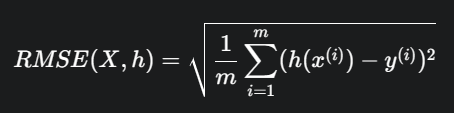

RMSE lebih sensitif terhadap outlier daripada Mean Absolute Error (MAE)

2. Mendapatkan Data (Get the Data)

- Dataset: California Housing Prices dataset dari repositori StatLib, berdasarkan data sensus California tahun 1990.


- Membuat Workspace:

In [2]:
# Perintah ini biasanya dijalankan di terminal Google Colab atau terminal lokal
# Tidak perlu dijalankan dalam sel Python biasa karena ini adalah perintah shell/bash

# Install library yang dibutuhkan (biasanya sudah ada di Colab)
# !pip install pandas numpy scikit-learn matplotlib scipy

# Membuat direktori kerja (jika belum ada)
# import os
# ML_PATH = os.path.join(os.getcwd(), "ml_project") # Contoh path di Colab
# os.makedirs(ML_PATH, exist_ok=True)
# os.chdir(ML_PATH) # Pindah ke direktori kerja

print("Workspace setup commands provided as comments.")
print("In Colab, libraries are often pre-installed, and direct folder creation is less critical.")

Workspace setup commands provided as comments.
In Colab, libraries are often pre-installed, and direct folder creation is less critical.


- Mengunduh Data:

In [ ]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True) # Buat folder jika belum ada
    tgz_path = os.path.join(housing_path, "housing.tgz")
    print(f"Mengunduh data dari: {housing_url} ke: {tgz_path}")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

print("Mengunduh data...")
fetch_housing_data()
print("Data berhasil diunduh dan diekstrak.")

- Melihat Struktur Data:

In [ ]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
print("\n--- 5 Baris Pertama Data (housing.head()) ---")
print(housing.head())
print("\n--- Informasi DataFrame (housing.info()) ---")
housing.info()
print("\n--- Jumlah Kategori 'ocean_proximity' (housing[\"ocean_proximity\"].value_counts()) ---")
print(housing["ocean_proximity"].value_counts())
print("\n--- Ringkasan Statistik Atribut Numerik (housing.describe()) ---")
print(housing.describe())
# Atribut total_bedrooms memiliki 207 nilai hilang.
# Atribut ocean_proximity adalah kategorikal (tipe object).

- Membuat Test Set: Hindari data snooping bias dengan memisahkan test set sejak awal.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Membuat kategori pendapatan (`income_cat`) untuk stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

print("\n--- Proporsi Kategori Pendapatan di Training/Test Set (Stratified Sampling) ---")
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print("Proporsi kategori pendapatan di test set:")
print(strat_test_set["income_cat"].value_counts(normalize=True))
print("Proporsi kategori pendapatan di training set:")
print(strat_train_set["income_cat"].value_counts(normalize=True))

# Menghapus atribut income_cat setelah split
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
print("Atribut 'income_cat' dihapus dari training dan test set.")

3. Menjelajahi dan Memvisualisasikan Data (Discover and Visualize the Data to Gain Insights)
Visualisasi Geografis:

In [ ]:
housing_explore = strat_train_set.copy() # Salinan untuk eksplorasi

# Scatterplot dengan kepadatan data tinggi
plt.figure(figsize=(8, 6))
housing_explore.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.title("Kepadatan Distrik di California")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Scatterplot dengan populasi (ukuran) dan harga rumah (warna)
plt.figure(figsize=(10, 7))
housing_explore.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                     s=housing_explore["population"]/100, label="Population", figsize=(10,7),
                     c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.title("Harga Rumah di California (Populasi & Nilai Median)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()
# Visualisasi menunjukkan harga terkait dengan lokasi (dekat laut) dan kepadatan populasi.

- Mencari Korelasi:

In [ ]:
corr_matrix = housing_explore.corr(numeric_only=True) # numeric_only=True untuk menghindari warning pandas
print("\n--- Korelasi 'median_house_value' dengan Atribut Lain ---")
print(corr_matrix["median_house_value"].sort_values(ascending=False))
# median_income memiliki korelasi positif yang kuat.
# Ada batasan harga di $500,000 dan garis horizontal lain.

Mengeksplorasi Kombinasi Atribut:
    housing_explore["rooms_per_household"] = housing_explore["total_rooms"] / housing_explore["households"]
housing_explore["bedrooms_per_room"] = housing_explore["total_bedrooms"] / housing_explore["total_rooms"]
housing_explore["population_per_household"] = housing_explore["population"] / housing_explore["households"]

4. Mempersiapkan Data untuk Algoritma Machine

- Learning (Prepare the Data for Machine Learning Algorithms)
- Memisahkan prediktor (housing) dan label (housing_labels) dari strat_train_set.
Pembersihan Data (Data Cleaning):

In [ ]:
from sklearn.impute import SimpleImputer

housing = strat_train_set.drop("median_house_value", axis=1) # Prediktor dari training set
housing_labels = strat_train_set["median_house_value"].copy() # Label dari training set

housing_num = housing.select_dtypes(include=np.number) # Pilih hanya kolom numerik
imputer = SimpleImputer(strategy="median") # Strategi mengisi dengan median
imputer.fit(housing_num) # Menghitung median untuk setiap atribut numerik
# Transformasi ini akan dilakukan dalam pipeline
print("\nSimpleImputer telah dilatih pada atribut numerik.")

- Menangani Atribut Teks dan Kategorikal:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
# OrdinalEncoder untuk demo, tapi OneHotEncoder lebih baik untuk kategori tanpa urutan
# from sklearn.preprocessing import OrdinalEncoder
# ordinal_encoder = OrdinalEncoder()
# housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False agar outputnya dense NumPy array
# Transformasi ini akan dilakukan dalam pipeline
print("OneHotEncoder telah didefinisikan untuk atribut kategorikal.")

- Custom Transformers:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Mendapatkan indeks kolom secara dinamis, mengacu pada kolom numerik setelah pemisahan
# Indeks ini akan digunakan di dalam CombinedAttributesAdder
_housing_num_temp_cols = housing.select_dtypes(include=np.number).columns
rooms_ix, bedrooms_ix, population_ix, households_ix = (
    _housing_num_temp_cols.get_loc("total_rooms"),
    _housing_num_temp_cols.get_loc("total_bedrooms"),
    _housing_num_temp_cols.get_loc("population"),
    _housing_num_temp_cols.get_loc("households")
)

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

print("Custom transformer 'CombinedAttributesAdder' telah didefinisikan.")

- Transformation Pipelines:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns) # Nama-nama kolom numerik
cat_attribs = ["ocean_proximity"] # Nama-nama kolom kategorikal

# Pipeline untuk atribut numerik
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()), # Custom transformer kita
    ('std_scaler', StandardScaler()), # Standardisasi fitur
])

# Menggabungkan pipeline numerik dan kategorikal menggunakan ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_attribs),
])

# Menerapkan pipeline ke data pelatihan
housing_prepared = full_pipeline.fit_transform(strat_train_set)
print("\nData telah dipersiapkan menggunakan full_pipeline (5 baris pertama):")
print(housing_prepared[:5])
print(f"Bentuk data yang dipersiapkan: {housing_prepared.shape}")

5. Memilih dan Melatih Model (Select and Train a Model)
- Melatih dan Mengevaluasi pada Training Set:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Linear Regression
print("\n--- Melatih Linear Regression ---")
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions_lin = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions_lin)
lin_rmse = np.sqrt(lin_mse)
print(f"Linear Regression RMSE pada training set: {lin_rmse:.4f} (Indikasi underfitting)")

# DecisionTreeRegressor
print("\n--- Melatih DecisionTreeRegressor ---")
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
print(f"Decision Tree RMSE pada training set: {tree_rmse:.4f} (Nilai 0.0 mengindikasikan overfitting parah)")

- Evaluasi yang Lebih Baik Menggunakan Cross-Validation:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor # Untuk model ensemble

def display_scores(scores):
    print("Scores (RMSE per fold):", np.round(scores, 4))
    print(f"Mean RMSE: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")

print("\n--- Evaluasi Model Menggunakan Cross-Validation ---")

print("\nDecision Tree Cross-Validation Scores (RMSE):")
scores_tree_cv = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores_cv = np.sqrt(-scores_tree_cv)
display_scores(tree_rmse_scores_cv)
# Hasil menunjukkan Decision Tree overfitting dan berkinerja lebih buruk dari Linear Regression di validasi.

print("\nLinear Regression Cross-Validation Scores (RMSE):")
scores_lin_cv = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                 scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores_cv = np.sqrt(-scores_lin_cv)
display_scores(lin_rmse_scores_cv)

# RandomForestRegressor (Ensemble Learning)
print("\nMelatih RandomForestRegressor...")
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

print("\nRandomForestRegressor Cross-Validation Scores (RMSE):")
scores_forest_cv = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                   scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores_cv = np.sqrt(-scores_forest_cv)
display_scores(forest_rmse_scores_cv)
# RandomForestRegressor menunjukkan hasil yang jauh lebih baik, namun masih ada indikasi overfitting.

6. Menyesuaikan Model (Fine-Tune Your Model)
- Grid Search:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # Set pertama parameter
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, # Set kedua parameter
]

forest_reg_gs = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg_gs, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1) # n_jobs=-1 untuk menggunakan semua core CPU

print("\n--- Melakukan Grid Search (Ini mungkin memakan waktu cukup lama) ---")
grid_search.fit(housing_prepared, housing_labels)
print("Grid Search selesai.")

print("\nHyperparameter terbaik:", grid_search.best_params_) # Parameter terbaik yang ditemukan
print("Estimator terbaik (model akhir setelah Grid Search):", grid_search.best_estimator_) # Estimator terbaik

cvres = grid_search.cv_results_
print("\nHasil Grid Search (RMSE per kombinasi hyperparameter):")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"  {np.sqrt(-mean_score):.4f}", params)
# RMSE sekitar 49,682 ditemukan lebih baik dari default.

- Randomized Search: Disebutkan sebagai alternatif yang lebih disukai untuk ruang pencarian hyperparameter yang besar

7. Menganalisis Model Terbaik dan Kesalahannya (Analyze the Best Models and Their Errors)
- Analisis Feature Importance:

In [ ]:
# Mendapatkan nama atribut setelah transformasi untuk analisis feature importance
# Nama-nama atribut numerik asli
num_attribs_raw = list(strat_train_set.select_dtypes(include=np.number).drop("median_house_value", axis=1).columns)

# Nama-nama atribut tambahan dari CombinedAttributesAdder
extra_attribs_names = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]

# Nama-nama atribut kategorikal setelah one-hot encoding
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs_names = list(cat_encoder.get_feature_names_out(cat_attribs))

# Gabungkan semua nama atribut yang diproses oleh full_pipeline
all_features_names = num_attribs_raw + extra_attribs_names + cat_one_hot_attribs_names

feature_importances = grid_search.best_estimator_.feature_importances_
sorted_feature_importances = sorted(zip(feature_importances, all_features_names), reverse=True)

print("\n--- Feature Importances (terurut dari yang terpenting) ---")
for score, name in sorted_feature_importances:
    print(f"  {name}: {score:.4f}")
# Informasi ini dapat digunakan untuk menghilangkan fitur yang kurang berguna.

8. Mengevaluasi Sistem pada Test Set (Evaluate Your System on the Test Set)
- Evaluasi model akhir pada test set setelah fine-tuning.

In [ ]:
final_model = grid_search.best_estimator_ # Model terbaik dari Grid Search

# Mempersiapkan test set (sudah dipisahkan di awal)
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Menerapkan pipeline transformasi ke test set (PENTING: gunakan .transform(), bukan .fit_transform())
X_test_prepared = full_pipeline.transform(X_test_raw)
final_predictions = final_model.predict(X_test_prepared)

# Menghitung RMSE akhir
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"\n--- Final RMSE pada Test Set: {final_rmse:.4f} ---")

# Menghitung interval kepercayaan 95% untuk RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
# stats.t.interval membutuhkan mean dan standard error dari kuadrat kesalahan
t_interval_result = stats.t.interval(confidence, len(squared_errors) - 1,
                                     loc=squared_errors.mean(),
                                     scale=stats.sem(squared_errors))
# Interval untuk RMSE adalah akar kuadrat dari interval untuk MSE
rmse_interval = np.sqrt(t_interval_result)

print(f"Interval kepercayaan 95% untuk RMSE: {rmse_interval}")
# Jika performa test set sedikit lebih buruk dari cross-validation, itu normal. Hindari tweak hyperparameter pada test set.

9. Meluncurkan, Memantau, dan Memelihara Sistem (Launch, Monitor, and Maintain Your System)
- Penyebaran (Deployment): Model dapat disimpan (joblib) dan disebarkan sebagai layanan web (REST API, gRPC) atau di platform cloud seperti Google Cloud AI Platform.
- Pemantauan (Monitoring): Memantau performa model secara langsung (model cenderung "membusuk" karena data berubah) dan kualitas data input.
- Pemeliharaan (Maintenance): Mengotomatiskan pengumpulan data baru, pelabelan, pelatihan ulang model, dan penyebaran model baru. Penting untuk memiliki backup model dan dataset